# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [2]:
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)


## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

- Method eval (pythorch): Set the model to evaluation mode, not training. No randomness introduced by the DropOut.
- Method .to(devide): Move the opeartions to de GPU in this case.

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'
print(f"Using device: {device}")

params_extractor = {
    "max_keypoints": 2048,
    # "nms_radius": 4,
    # "keypoint_threshold": 0.015,
}

params_matcher = {
    "features": "superpoint", 
    # "max_distance": 0.7,
    # "max_num_matches": 100,
    # "confidence_threshold": 0.8
}

extractor   =   SuperPoint(**params_extractor).eval().to(device)
matcher     =   LightGlue(**params_matcher).eval().to(device)

print("Extractor y matcher inicializados con los siguientes parámetros:")
print("Extractor:", params_extractor)
print("Matcher:", params_matcher)

Using device: cpu
Extractor y matcher inicializados con los siguientes parámetros:
Extractor: {'max_keypoints': 2048}
Matcher: {'features': 'superpoint'}


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

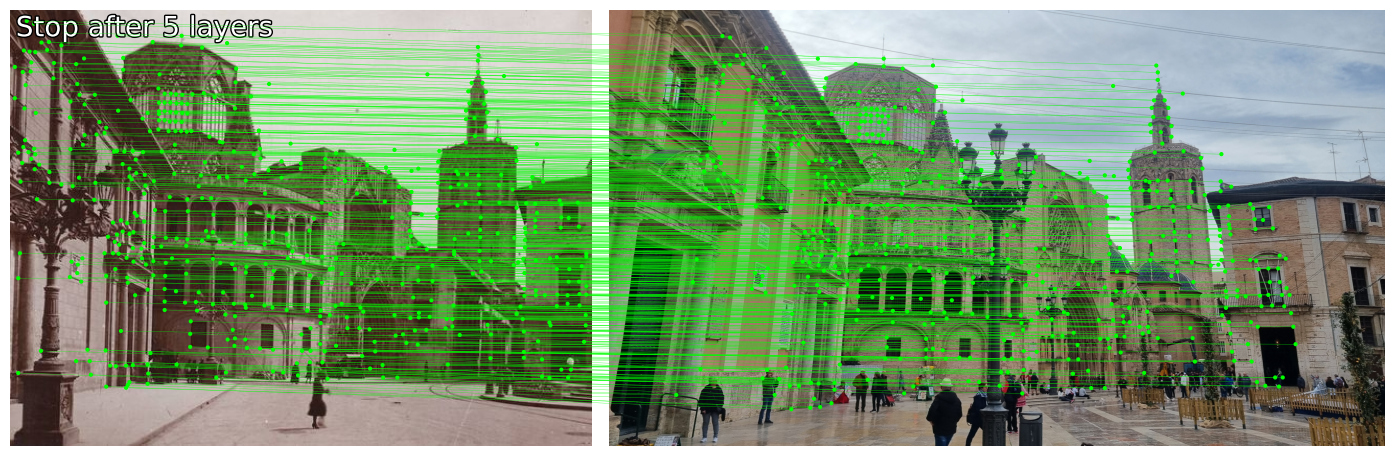

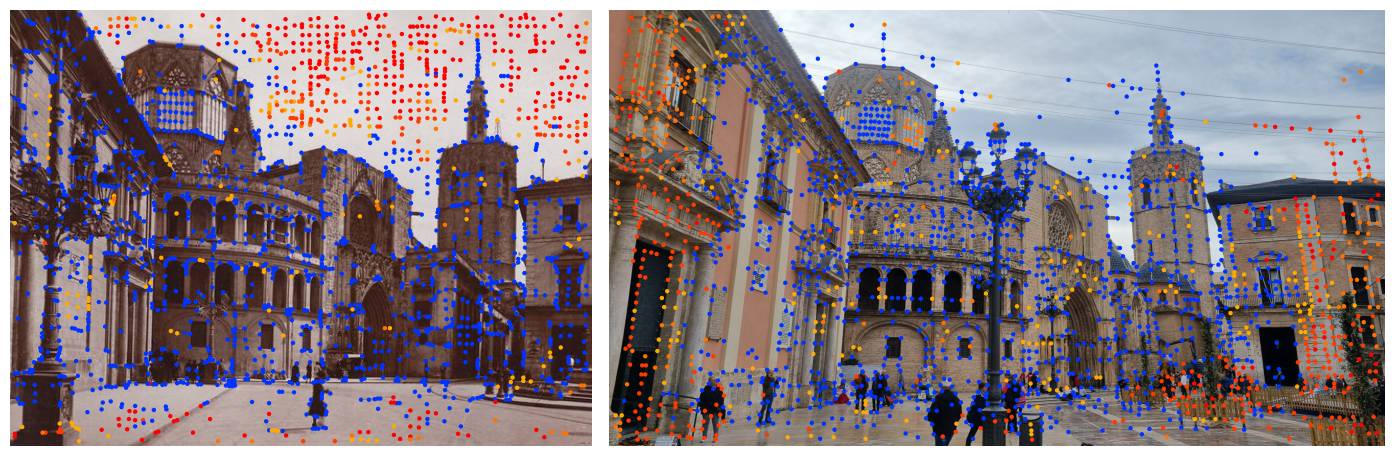

In [24]:
image0 = load_image("original.jpg")
image1 = load_image("Img02_Try2_12M.jpg")

# Usamos SuperPoint para extraer las features de las imágenes
feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))

# Usamos LightGlue para hacer el matching de las features
# Saca correspondencias, y estadísticas de pruning
matches01 = matcher({"image0": feats0, "image1": feats1})
# TODO: 
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension


kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
# Coordenadas de los puntos que hacen match
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]


axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

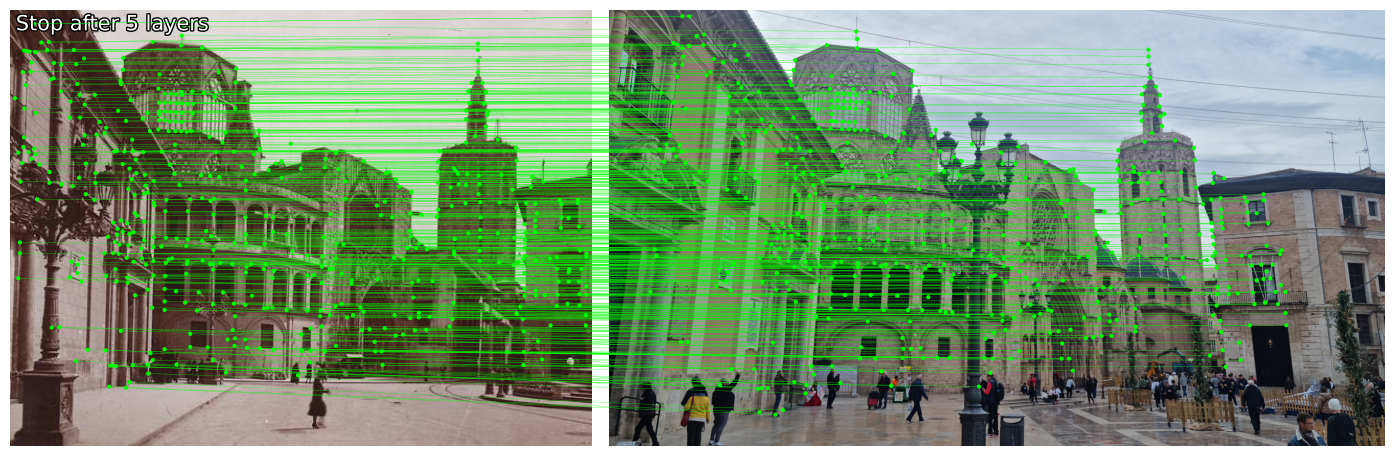

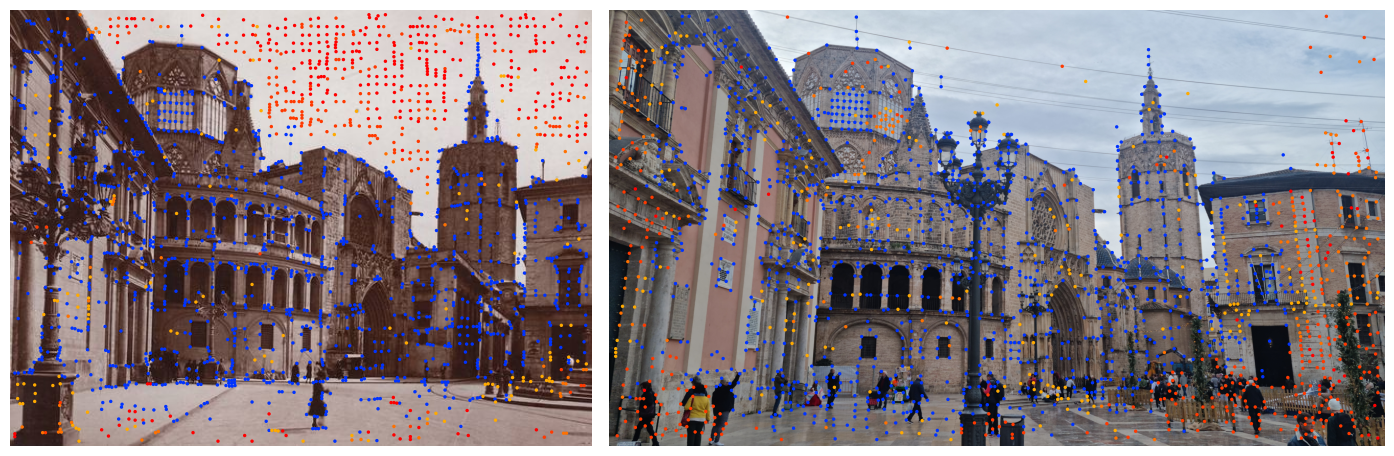

In [25]:
image0 = load_image("original.jpg")
image1 = load_image("Img02_Try2_64M.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)

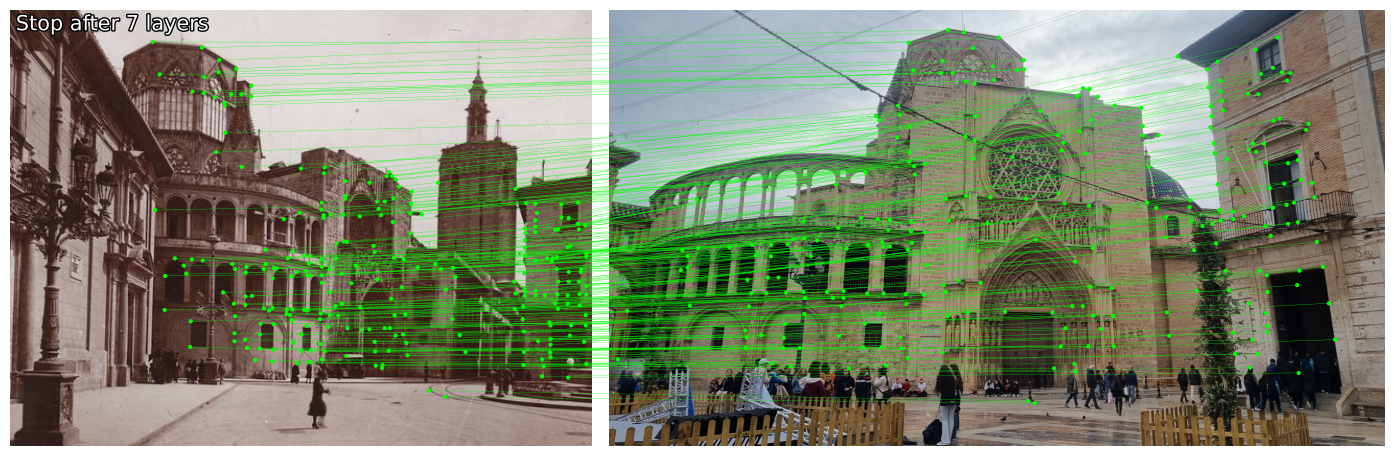

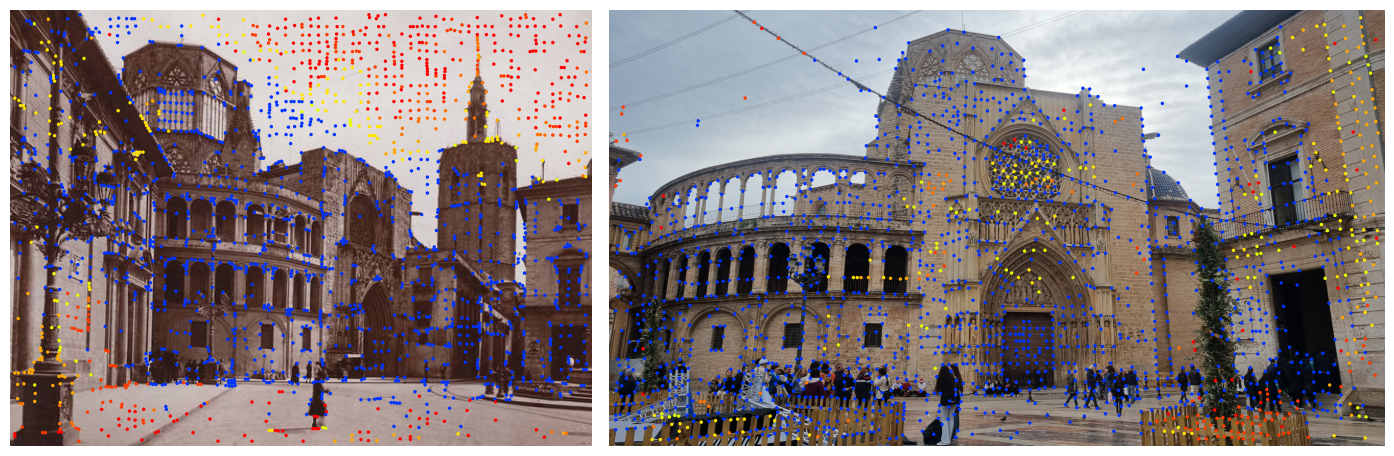

In [26]:
image0 = load_image("original.jpg")
image1 = load_image("Img31_Try1_12M.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)